## Import library

In [1]:
import os
import subprocess
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from tqdm.notebook import tqdm
import itertools

import torch
from qucumber.nn_states import DensityMatrix
from qucumber.nn_states import ComplexWaveFunction
from qucumber.callbacks import MetricEvaluator
import qucumber.utils.unitaries as unitaries
import qucumber.utils.training_statistics as ts
import qucumber.utils.cplx as cplx
import qucumber.utils.data as data
from qucumber.observables import ObservableBase, to_pm1
from qucumber.observables.pauli import flip_spin
import qucumber

from qulacs.gate import Pauli

with open('./params_setting.yaml', 'r') as yml:
    params = yaml.safe_load(yml)
    
# quantum circuit parameter
n_qubit = params["circuit_info"]["n_qubit"]
each_n_shot = params["circuit_info"]["each_n_shot"]
state_name = params["circuit_info"]["state_name"]
error_model = params["circuit_info"]["error_model"]
error_rate = params["circuit_info"]["error_rate"]
# RBM architecture parameter
n_visible_unit = params["architecture_info"]["n_visible_unit"]
n_hidden_unit = params["architecture_info"]["n_hidden_unit"] 
n_aux_unit = params["architecture_info"]["n_aux_unit"]
# train parameter
lr = params["train_info"]["lr"]
pbs = params["train_info"]["positive_batch_size"]
nbs = params["train_info"]["negative_batch_size"]
n_gibbs_step = params["train_info"]["n_gibbs_step"]
period = 1
epoch = params["train_info"]["n_epoch"]
lr_drop_epoch = params["train_info"]["lr_drop_epoch"]
lr_drop_factor = params["train_info"]["lr_drop_factor"]
seed = params["train_info"]["seed"]
# sampling parameter
n_sampling = params["sampling_info"]["n_sample"]
n_copy = params["sampling_info"]["n_copy"]
# data path info
train_data_path = f"./data/{error_model}/error_prob_{100*error_rate}%/num_of_data_{each_n_shot}/"
ideal_state_path = f"./target_state/"

# settings
## warnings
warnings.simplefilter('ignore')

## seaborn layout
sns.set()
sns.set_style("white")

## seed
def seed_settings(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    qucumber.set_random_seed(seed, cpu=True, gpu=False)

seed_settings(seed=seed)

## caluculate ideal state

In [2]:
# calculate ideal state
is_ideal_state_file = os.path.exists(ideal_state_path)
if is_ideal_state_file:
    print("ideal state data is exsisted !")
else:
    print("caluculate ideal state data ...")
    os.makedirs(ideal_state_path, exist_ok = True)
    subprocess.run("python caluculate_ideal_state.py", shell=True)
    print("ideal state data is ready !")

caluculate ideal state data ...
ideal state data is ready !


## generate dataset

In [3]:
# generate train data
is_train_data_file = os.path.exists(train_data_path)
if is_train_data_file:
    print("train data is exsisted !")
else:
    print("generate directries & train data ...")
    os.makedirs(train_data_path, exist_ok = True)
    subprocess.run("python generate_dataset.py", shell=True)
    print("train data is ready !")

generate directries & train data ...


0it [00:00, ?it/s]
  1%|          | 11/1000 [00:00<00:09, 104.34it/s]

measurement pattern 0 : ('X', 'X', 'X', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 104.68it/s][A
1it [00:09,  9.55s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 1 : ('X', 'X', 'X', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 103.64it/s][A
2it [00:19,  9.61s/it]
  1%|          | 11/1000 [00:00<00:09, 107.91it/s]

measurement pattern 2 : ('X', 'X', 'X', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 104.39it/s][A
3it [00:28,  9.60s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 3 : ('X', 'X', 'X', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.28it/s][A
4it [00:38,  9.56s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 4 : ('X', 'X', 'X', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 104.68it/s][A
5it [00:47,  9.56s/it]
  1%|          | 11/1000 [00:00<00:09, 105.88it/s]

measurement pattern 5 : ('X', 'X', 'X', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 104.93it/s][A
6it [00:57,  9.55s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 6 : ('X', 'X', 'X', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.76it/s][A
7it [01:06,  9.52s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 7 : ('X', 'X', 'X', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.07it/s][A
8it [01:16,  9.52s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 8 : ('X', 'X', 'X', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.00it/s][A
9it [01:25,  9.49s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 9 : ('X', 'X', 'Y', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 104.31it/s][A
10it [01:35,  9.52s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 10 : ('X', 'X', 'Y', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 104.63it/s][A
11it [01:44,  9.53s/it]


measurement pattern 11 : ('X', 'X', 'Y', 'X', 'Z')


100%|██████████| 1000/1000 [00:09<00:00, 105.75it/s][A
12it [01:54,  9.51s/it]
  1%|          | 11/1000 [00:00<00:09, 106.48it/s]

measurement pattern 12 : ('X', 'X', 'Y', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.19it/s][A
13it [02:03,  9.51s/it]
  1%|          | 11/1000 [00:00<00:09, 105.58it/s]

measurement pattern 13 : ('X', 'X', 'Y', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 104.96it/s][A
14it [02:13,  9.51s/it]
  1%|          | 11/1000 [00:00<00:09, 105.75it/s]

measurement pattern 14 : ('X', 'X', 'Y', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.12it/s][A
15it [02:22,  9.51s/it]
  1%|          | 11/1000 [00:00<00:09, 106.87it/s]

measurement pattern 15 : ('X', 'X', 'Y', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 104.77it/s][A
16it [02:32,  9.52s/it]
  1%|          | 11/1000 [00:00<00:09, 104.88it/s]

measurement pattern 16 : ('X', 'X', 'Y', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.11it/s][A
17it [02:41,  9.52s/it]
  1%|          | 11/1000 [00:00<00:09, 107.70it/s]

measurement pattern 17 : ('X', 'X', 'Y', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.71it/s][A
18it [02:51,  9.50s/it]
  1%|          | 11/1000 [00:00<00:09, 107.23it/s]

measurement pattern 18 : ('X', 'X', 'Z', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 104.24it/s][A
19it [03:01,  9.53s/it]
  1%|          | 11/1000 [00:00<00:09, 106.07it/s]

measurement pattern 19 : ('X', 'X', 'Z', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.42it/s][A
20it [03:10,  9.52s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 20 : ('X', 'X', 'Z', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.53it/s][A
21it [03:19,  9.50s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 21 : ('X', 'X', 'Z', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 104.96it/s][A
22it [03:29,  9.51s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 22 : ('X', 'X', 'Z', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 104.33it/s][A
23it [03:39,  9.53s/it]
  1%|          | 11/1000 [00:00<00:09, 102.69it/s]

measurement pattern 23 : ('X', 'X', 'Z', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.52it/s][A
24it [03:48,  9.52s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 24 : ('X', 'X', 'Z', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.85it/s][A
25it [03:58,  9.50s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 25 : ('X', 'X', 'Z', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.50it/s][A
26it [04:07,  9.49s/it]
  1%|          | 11/1000 [00:00<00:09, 108.36it/s]

measurement pattern 26 : ('X', 'X', 'Z', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.96it/s][A
27it [04:16,  9.48s/it]
  1%|          | 11/1000 [00:00<00:09, 106.99it/s]

measurement pattern 27 : ('X', 'Y', 'X', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.19it/s][A
28it [04:26,  9.46s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 28 : ('X', 'Y', 'X', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 104.63it/s][A
29it [04:35,  9.49s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 29 : ('X', 'Y', 'X', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.34it/s][A
30it [04:45,  9.49s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 30 : ('X', 'Y', 'X', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.40it/s][A
31it [04:54,  9.49s/it]
  1%|          | 11/1000 [00:00<00:09, 106.71it/s]

measurement pattern 31 : ('X', 'Y', 'X', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 104.78it/s][A
32it [05:04,  9.51s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 32 : ('X', 'Y', 'X', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.32it/s][A
33it [05:13,  9.50s/it]
  1%|          | 11/1000 [00:00<00:09, 104.99it/s]

measurement pattern 33 : ('X', 'Y', 'X', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.84it/s][A
34it [05:23,  9.49s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 34 : ('X', 'Y', 'X', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.62it/s][A
35it [05:32,  9.48s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 35 : ('X', 'Y', 'X', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.27it/s][A
36it [05:42,  9.49s/it]
  1%|          | 11/1000 [00:00<00:09, 104.04it/s]

measurement pattern 36 : ('X', 'Y', 'Y', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.69it/s][A
37it [05:51,  9.48s/it]
  1%|          | 11/1000 [00:00<00:09, 105.22it/s]

measurement pattern 37 : ('X', 'Y', 'Y', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 104.86it/s][A
38it [06:01,  9.50s/it]
  1%|          | 11/1000 [00:00<00:09, 106.32it/s]

measurement pattern 38 : ('X', 'Y', 'Y', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 104.87it/s][A
39it [06:10,  9.51s/it]
  1%|          | 11/1000 [00:00<00:09, 105.97it/s]

measurement pattern 39 : ('X', 'Y', 'Y', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.56it/s][A
40it [06:20,  9.50s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 40 : ('X', 'Y', 'Y', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 104.91it/s][A
41it [06:29,  9.51s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 41 : ('X', 'Y', 'Y', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 104.82it/s][A
42it [06:39,  9.52s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 42 : ('X', 'Y', 'Y', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.94it/s][A
43it [06:48,  9.49s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 43 : ('X', 'Y', 'Y', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.37it/s][A
44it [06:58,  9.49s/it]
  1%|          | 11/1000 [00:00<00:09, 100.87it/s]

measurement pattern 44 : ('X', 'Y', 'Y', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.71it/s][A
45it [07:07,  9.48s/it]
  1%|          | 11/1000 [00:00<00:09, 105.09it/s]

measurement pattern 45 : ('X', 'Y', 'Z', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.01it/s][A
46it [07:17,  9.47s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 46 : ('X', 'Y', 'Z', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.01it/s][A
47it [07:26,  9.46s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 47 : ('X', 'Y', 'Z', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.00it/s][A
48it [07:36,  9.45s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 48 : ('X', 'Y', 'Z', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.08it/s][A
49it [07:45,  9.47s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 49 : ('X', 'Y', 'Z', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.44it/s][A
50it [07:55,  9.47s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 50 : ('X', 'Y', 'Z', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.49it/s][A
51it [08:04,  9.48s/it]
  1%|          | 11/1000 [00:00<00:09, 103.66it/s]

measurement pattern 51 : ('X', 'Y', 'Z', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.92it/s][A
52it [08:14,  9.47s/it]
  1%|          | 11/1000 [00:00<00:09, 107.08it/s]

measurement pattern 52 : ('X', 'Y', 'Z', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.50it/s][A
53it [08:23,  9.47s/it]
  1%|          | 11/1000 [00:00<00:09, 104.16it/s]

measurement pattern 53 : ('X', 'Y', 'Z', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.02it/s][A
54it [08:32,  9.46s/it]
  1%|          | 11/1000 [00:00<00:09, 108.09it/s]

measurement pattern 54 : ('X', 'Z', 'X', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.67it/s][A
55it [08:42,  9.46s/it]
  1%|          | 11/1000 [00:00<00:09, 104.24it/s]

measurement pattern 55 : ('X', 'Z', 'X', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.22it/s][A
56it [08:51,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 104.57it/s]

measurement pattern 56 : ('X', 'Z', 'X', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.34it/s][A
57it [09:01,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 104.87it/s]

measurement pattern 57 : ('X', 'Z', 'X', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.19it/s][A
58it [09:10,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 58 : ('X', 'Z', 'X', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.44it/s][A
59it [09:20,  9.45s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 59 : ('X', 'Z', 'X', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.07it/s][A
60it [09:29,  9.44s/it]
  1%|          | 11/1000 [00:00<00:09, 108.01it/s]

measurement pattern 60 : ('X', 'Z', 'X', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.43it/s][A
61it [09:38,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 107.08it/s]

measurement pattern 61 : ('X', 'Z', 'X', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.09it/s][A
62it [09:48,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 107.73it/s]

measurement pattern 62 : ('X', 'Z', 'X', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 104.94it/s]
63it [09:58,  9.48s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 63 : ('X', 'Z', 'Y', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.71it/s][A
64it [10:07,  9.47s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 64 : ('X', 'Z', 'Y', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 104.84it/s][A
65it [10:17,  9.49s/it]
  1%|          | 11/1000 [00:00<00:09, 107.47it/s]

measurement pattern 65 : ('X', 'Z', 'Y', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.04it/s][A
66it [10:26,  9.47s/it]
  1%|          | 11/1000 [00:00<00:09, 105.49it/s]

measurement pattern 66 : ('X', 'Z', 'Y', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.52it/s][A
67it [10:35,  9.47s/it]
  1%|          | 11/1000 [00:00<00:09, 107.04it/s]

measurement pattern 67 : ('X', 'Z', 'Y', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 104.89it/s][A
68it [10:45,  9.49s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 68 : ('X', 'Z', 'Y', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.91it/s][A
69it [10:54,  9.48s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 69 : ('X', 'Z', 'Y', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.81it/s][A
70it [11:04,  9.47s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 70 : ('X', 'Z', 'Y', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.91it/s][A
71it [11:13,  9.46s/it]
  1%|          | 11/1000 [00:00<00:09, 107.65it/s]

measurement pattern 71 : ('X', 'Z', 'Y', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.10it/s][A
72it [11:23,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 107.55it/s]

measurement pattern 72 : ('X', 'Z', 'Z', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.66it/s][A
73it [11:32,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 107.08it/s]

measurement pattern 73 : ('X', 'Z', 'Z', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.18it/s][A
74it [11:42,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 74 : ('X', 'Z', 'Z', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.10it/s][A
75it [11:51,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 104.50it/s]

measurement pattern 75 : ('X', 'Z', 'Z', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.89it/s][A
76it [12:00,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 107.05it/s]

measurement pattern 76 : ('X', 'Z', 'Z', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.88it/s][A
77it [12:10,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 107.06it/s]

measurement pattern 77 : ('X', 'Z', 'Z', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.81it/s][A
78it [12:19,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 106.77it/s]

measurement pattern 78 : ('X', 'Z', 'Z', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.68it/s][A
79it [12:29,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 106.99it/s]

measurement pattern 79 : ('X', 'Z', 'Z', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.11it/s][A
80it [12:38,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]


measurement pattern 80 : ('X', 'Z', 'Z', 'Z', 'Z')


100%|██████████| 1000/1000 [00:09<00:00, 105.67it/s][A
81it [12:48,  9.44s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 81 : ('Y', 'X', 'X', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.37it/s][A
82it [12:57,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 82 : ('Y', 'X', 'X', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.00it/s][A
83it [13:06,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 83 : ('Y', 'X', 'X', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.41it/s][A
84it [13:16,  9.42s/it]
  1%|          | 11/1000 [00:00<00:09, 100.86it/s]

measurement pattern 84 : ('Y', 'X', 'X', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.94it/s][A
85it [13:25,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 85 : ('Y', 'X', 'X', 'Y', 'Y')



 99%|█████████▉| 990/1000 [00:09<00:00, 105.94it/s]

measurement pattern 86 : ('Y', 'X', 'X', 'Y', 'Z')


100%|██████████| 1000/1000 [00:09<00:00, 105.51it/s]
86it [13:35,  9.44s/it]
100%|██████████| 1000/1000 [00:09<00:00, 106.22it/s][A
87it [13:44,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 107.53it/s]

measurement pattern 87 : ('Y', 'X', 'X', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.65it/s][A
88it [13:54,  9.44s/it]
  1%|          | 11/1000 [00:00<00:09, 105.25it/s]

measurement pattern 88 : ('Y', 'X', 'X', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.67it/s][A
89it [14:03,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 107.63it/s]

measurement pattern 89 : ('Y', 'X', 'X', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.61it/s][A
90it [14:13,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 106.61it/s]

measurement pattern 90 : ('Y', 'X', 'Y', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.64it/s][A
91it [14:22,  9.44s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 91 : ('Y', 'X', 'Y', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.00it/s][A
92it [14:31,  9.44s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 92 : ('Y', 'X', 'Y', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.01it/s][A
93it [14:41,  9.44s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 93 : ('Y', 'X', 'Y', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 104.55it/s][A
94it [14:50,  9.48s/it]
  1%|          | 11/1000 [00:00<00:09, 104.38it/s]

measurement pattern 94 : ('Y', 'X', 'Y', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.64it/s][A
95it [15:00,  9.47s/it]
  1%|          | 11/1000 [00:00<00:09, 105.82it/s]

measurement pattern 95 : ('Y', 'X', 'Y', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.77it/s][A
96it [15:09,  9.47s/it]
  1%|          | 11/1000 [00:00<00:09, 105.65it/s]

measurement pattern 96 : ('Y', 'X', 'Y', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.22it/s][A
97it [15:19,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 103.80it/s]

measurement pattern 97 : ('Y', 'X', 'Y', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.65it/s][A
98it [15:28,  9.46s/it]
  1%|          | 11/1000 [00:00<00:09, 108.48it/s]

measurement pattern 98 : ('Y', 'X', 'Y', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.89it/s][A
99it [15:38,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 106.74it/s]

measurement pattern 99 : ('Y', 'X', 'Z', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.64it/s][A
100it [15:47,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 103.31it/s]

measurement pattern 100 : ('Y', 'X', 'Z', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.13it/s][A
101it [15:57,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 107.90it/s]

measurement pattern 101 : ('Y', 'X', 'Z', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.21it/s][A
102it [16:06,  9.44s/it]
  1%|          | 11/1000 [00:00<00:09, 105.02it/s]

measurement pattern 102 : ('Y', 'X', 'Z', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.04it/s][A
103it [16:15,  9.44s/it]
  1%|          | 11/1000 [00:00<00:09, 106.39it/s]

measurement pattern 103 : ('Y', 'X', 'Z', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.97it/s][A
104it [16:25,  9.44s/it]
  1%|          | 11/1000 [00:00<00:09, 108.44it/s]

measurement pattern 104 : ('Y', 'X', 'Z', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.01it/s][A
105it [16:34,  9.44s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 105 : ('Y', 'X', 'Z', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.35it/s][A
106it [16:44,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 106 : ('Y', 'X', 'Z', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.63it/s][A
107it [16:53,  9.44s/it]
  1%|          | 11/1000 [00:00<00:09, 103.41it/s]

measurement pattern 107 : ('Y', 'X', 'Z', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.32it/s][A
108it [17:03,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 107.81it/s]

measurement pattern 108 : ('Y', 'Y', 'X', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.35it/s][A
109it [17:12,  9.42s/it]
  1%|          | 11/1000 [00:00<00:09, 107.71it/s]

measurement pattern 109 : ('Y', 'Y', 'X', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.74it/s][A
110it [17:21,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 106.88it/s]

measurement pattern 110 : ('Y', 'Y', 'X', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.04it/s][A
111it [17:31,  9.46s/it]
  1%|          | 11/1000 [00:00<00:09, 106.54it/s]

measurement pattern 111 : ('Y', 'Y', 'X', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.87it/s][A
112it [17:40,  9.45s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 112 : ('Y', 'Y', 'X', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.11it/s][A
113it [17:50,  9.47s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 113 : ('Y', 'Y', 'X', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.21it/s][A
114it [17:59,  9.48s/it]


measurement pattern 114 : ('Y', 'Y', 'X', 'Z', 'X')


100%|██████████| 1000/1000 [00:09<00:00, 105.86it/s][A
115it [18:09,  9.47s/it]
  1%|          | 11/1000 [00:00<00:09, 107.44it/s]

measurement pattern 115 : ('Y', 'Y', 'X', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.81it/s][A
116it [18:18,  9.47s/it]
  1%|          | 11/1000 [00:00<00:09, 107.74it/s]

measurement pattern 116 : ('Y', 'Y', 'X', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.09it/s][A
117it [18:28,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 104.98it/s]

measurement pattern 117 : ('Y', 'Y', 'Y', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.74it/s][A
118it [18:37,  9.46s/it]
  1%|          | 11/1000 [00:00<00:09, 105.98it/s]

measurement pattern 118 : ('Y', 'Y', 'Y', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.75it/s][A
119it [18:47,  9.46s/it]
  1%|          | 11/1000 [00:00<00:09, 106.96it/s]

measurement pattern 119 : ('Y', 'Y', 'Y', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.35it/s][A
120it [18:56,  9.47s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 120 : ('Y', 'Y', 'Y', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.29it/s][A
121it [19:06,  9.48s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 121 : ('Y', 'Y', 'Y', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.34it/s][A
122it [19:15,  9.48s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 122 : ('Y', 'Y', 'Y', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.33it/s][A
123it [19:25,  9.49s/it]
  1%|          | 11/1000 [00:00<00:09, 105.55it/s]

measurement pattern 123 : ('Y', 'Y', 'Y', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.21it/s][A
124it [19:34,  9.46s/it]
  1%|          | 11/1000 [00:00<00:09, 106.55it/s]

measurement pattern 124 : ('Y', 'Y', 'Y', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.79it/s][A
125it [19:43,  9.46s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 125 : ('Y', 'Y', 'Y', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.42it/s][A
126it [19:53,  9.47s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 126 : ('Y', 'Y', 'Z', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.46it/s][A
127it [20:02,  9.47s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 127 : ('Y', 'Y', 'Z', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.94it/s][A
128it [20:12,  9.46s/it]


measurement pattern 128 : ('Y', 'Y', 'Z', 'X', 'Z')


100%|██████████| 1000/1000 [00:09<00:00, 106.11it/s][A
129it [20:21,  9.45s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 129 : ('Y', 'Y', 'Z', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.76it/s][A
130it [20:31,  9.45s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 130 : ('Y', 'Y', 'Z', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 104.65it/s][A
131it [20:40,  9.48s/it]
  1%|          | 11/1000 [00:00<00:09, 104.58it/s]

measurement pattern 131 : ('Y', 'Y', 'Z', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.31it/s][A
132it [20:50,  9.49s/it]
  1%|          | 11/1000 [00:00<00:09, 106.71it/s]

measurement pattern 132 : ('Y', 'Y', 'Z', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.68it/s][A
133it [20:59,  9.48s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 133 : ('Y', 'Y', 'Z', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.18it/s][A
134it [21:09,  9.49s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 134 : ('Y', 'Y', 'Z', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.43it/s][A
135it [21:18,  9.46s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 135 : ('Y', 'Z', 'X', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.47it/s][A
136it [21:28,  9.47s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 136 : ('Y', 'Z', 'X', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.04it/s][A
137it [21:37,  9.46s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 137 : ('Y', 'Z', 'X', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.76it/s][A
138it [21:46,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 138 : ('Y', 'Z', 'X', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.20it/s][A
139it [21:56,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 139 : ('Y', 'Z', 'X', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.02it/s][A
140it [22:05,  9.45s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 140 : ('Y', 'Z', 'X', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.01it/s][A
141it [22:15,  9.45s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 141 : ('Y', 'Z', 'X', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.17it/s][A
142it [22:24,  9.44s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 142 : ('Y', 'Z', 'X', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.31it/s][A
143it [22:34,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 143 : ('Y', 'Z', 'X', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.32it/s][A
144it [22:43,  9.42s/it]
  1%|          | 11/1000 [00:00<00:09, 105.61it/s]

measurement pattern 144 : ('Y', 'Z', 'Y', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.73it/s][A
145it [22:53,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 107.27it/s]

measurement pattern 145 : ('Y', 'Z', 'Y', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.09it/s][A
146it [23:02,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 146 : ('Y', 'Z', 'Y', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.39it/s][A
147it [23:11,  9.45s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 147 : ('Y', 'Z', 'Y', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.85it/s][A
148it [23:21,  9.45s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 148 : ('Y', 'Z', 'Y', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.58it/s][A
149it [23:30,  9.46s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 149 : ('Y', 'Z', 'Y', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.89it/s][A
150it [23:40,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 107.74it/s]

measurement pattern 150 : ('Y', 'Z', 'Y', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.33it/s][A
151it [23:49,  9.44s/it]
  1%|          | 11/1000 [00:00<00:09, 106.00it/s]

measurement pattern 151 : ('Y', 'Z', 'Y', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.01it/s][A
152it [23:59,  9.44s/it]
  1%|          | 11/1000 [00:00<00:09, 105.54it/s]

measurement pattern 152 : ('Y', 'Z', 'Y', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.24it/s][A
153it [24:08,  9.46s/it]
  1%|          | 11/1000 [00:00<00:09, 107.96it/s]

measurement pattern 153 : ('Y', 'Z', 'Z', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.53it/s][A
154it [24:18,  9.44s/it]
  1%|          | 11/1000 [00:00<00:09, 107.53it/s]

measurement pattern 154 : ('Y', 'Z', 'Z', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.46it/s][A
155it [24:27,  9.42s/it]
  1%|          | 11/1000 [00:00<00:09, 106.67it/s]

measurement pattern 155 : ('Y', 'Z', 'Z', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.54it/s][A
156it [24:36,  9.41s/it]
  1%|          | 11/1000 [00:00<00:09, 106.20it/s]

measurement pattern 156 : ('Y', 'Z', 'Z', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.15it/s][A
157it [24:46,  9.41s/it]
  1%|          | 11/1000 [00:00<00:09, 106.51it/s]

measurement pattern 157 : ('Y', 'Z', 'Z', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.68it/s][A
158it [24:55,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 106.09it/s]

measurement pattern 158 : ('Y', 'Z', 'Z', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.10it/s][A
159it [25:05,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 104.52it/s]

measurement pattern 159 : ('Y', 'Z', 'Z', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.94it/s][A
160it [25:14,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 106.50it/s]

measurement pattern 160 : ('Y', 'Z', 'Z', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 104.23it/s][A
161it [25:24,  9.48s/it]
  1%|          | 11/1000 [00:00<00:09, 106.34it/s]

measurement pattern 161 : ('Y', 'Z', 'Z', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.67it/s][A
162it [25:33,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 108.51it/s]

measurement pattern 162 : ('Z', 'X', 'X', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.75it/s][A
163it [25:42,  9.42s/it]
  1%|          | 11/1000 [00:00<00:09, 107.07it/s]

measurement pattern 163 : ('Z', 'X', 'X', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.53it/s][A
164it [25:52,  9.41s/it]
  1%|          | 11/1000 [00:00<00:09, 106.59it/s]

measurement pattern 164 : ('Z', 'X', 'X', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.85it/s][A
165it [26:01,  9.40s/it]
  1%|          | 11/1000 [00:00<00:09, 107.07it/s]

measurement pattern 165 : ('Z', 'X', 'X', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.66it/s][A
166it [26:11,  9.42s/it]
  1%|          | 11/1000 [00:00<00:09, 105.73it/s]

measurement pattern 166 : ('Z', 'X', 'X', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.39it/s][A
167it [26:20,  9.41s/it]
  1%|          | 11/1000 [00:00<00:09, 105.54it/s]

measurement pattern 167 : ('Z', 'X', 'X', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.76it/s][A
168it [26:29,  9.40s/it]
  1%|          | 11/1000 [00:00<00:09, 107.04it/s]

measurement pattern 168 : ('Z', 'X', 'X', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.23it/s][A
169it [26:39,  9.40s/it]
  1%|          | 11/1000 [00:00<00:09, 107.07it/s]

measurement pattern 169 : ('Z', 'X', 'X', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.47it/s][A
170it [26:48,  9.40s/it]
  1%|          | 11/1000 [00:00<00:09, 108.75it/s]

measurement pattern 170 : ('Z', 'X', 'X', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 107.02it/s][A
171it [26:58,  9.38s/it]
  1%|          | 11/1000 [00:00<00:09, 105.30it/s]

measurement pattern 171 : ('Z', 'X', 'Y', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.55it/s][A
172it [27:07,  9.38s/it]
  1%|          | 11/1000 [00:00<00:09, 106.41it/s]

measurement pattern 172 : ('Z', 'X', 'Y', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.78it/s][A
173it [27:16,  9.40s/it]
  1%|          | 11/1000 [00:00<00:09, 108.55it/s]

measurement pattern 173 : ('Z', 'X', 'Y', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.54it/s][A
174it [27:26,  9.40s/it]
  1%|          | 11/1000 [00:00<00:09, 104.24it/s]

measurement pattern 174 : ('Z', 'X', 'Y', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.43it/s][A
175it [27:35,  9.40s/it]
  1%|          | 11/1000 [00:00<00:09, 107.93it/s]

measurement pattern 175 : ('Z', 'X', 'Y', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.09it/s][A
176it [27:45,  9.41s/it]
  1%|          | 11/1000 [00:00<00:09, 104.80it/s]

measurement pattern 176 : ('Z', 'X', 'Y', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.20it/s][A
177it [27:54,  9.41s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 177 : ('Z', 'X', 'Y', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.44it/s][A
178it [28:03,  9.41s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 178 : ('Z', 'X', 'Y', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.26it/s][A


measurement pattern 179 : ('Z', 'X', 'Y', 'Z', 'Z')


179it [28:13,  9.43s/it]
100%|██████████| 1000/1000 [00:09<00:00, 105.89it/s][A
180it [28:22,  9.44s/it]
  1%|          | 11/1000 [00:00<00:09, 105.79it/s]

measurement pattern 180 : ('Z', 'X', 'Z', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.61it/s][A
181it [28:32,  9.42s/it]
  1%|          | 11/1000 [00:00<00:09, 107.25it/s]

measurement pattern 181 : ('Z', 'X', 'Z', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.31it/s][A
182it [28:41,  9.44s/it]
  1%|          | 11/1000 [00:00<00:09, 107.14it/s]

measurement pattern 182 : ('Z', 'X', 'Z', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.47it/s][A
183it [28:51,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 183 : ('Z', 'X', 'Z', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.32it/s][A
184it [29:00,  9.42s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 184 : ('Z', 'X', 'Z', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.16it/s][A
185it [29:09,  9.42s/it]
  1%|          | 11/1000 [00:00<00:09, 107.34it/s]

measurement pattern 185 : ('Z', 'X', 'Z', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.70it/s][A
186it [29:19,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 108.40it/s]

measurement pattern 186 : ('Z', 'X', 'Z', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 107.08it/s][A
187it [29:28,  9.40s/it]
  1%|          | 11/1000 [00:00<00:09, 106.99it/s]

measurement pattern 187 : ('Z', 'X', 'Z', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.69it/s][A
188it [29:38,  9.40s/it]
  1%|          | 11/1000 [00:00<00:09, 107.04it/s]

measurement pattern 188 : ('Z', 'X', 'Z', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 107.02it/s][A
189it [29:47,  9.38s/it]
  1%|          | 11/1000 [00:00<00:09, 106.38it/s]

measurement pattern 189 : ('Z', 'Y', 'X', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.40it/s][A
190it [29:56,  9.39s/it]
  1%|          | 11/1000 [00:00<00:09, 107.77it/s]

measurement pattern 190 : ('Z', 'Y', 'X', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.31it/s][A
191it [30:06,  9.39s/it]
  1%|          | 11/1000 [00:00<00:09, 107.32it/s]

measurement pattern 191 : ('Z', 'Y', 'X', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.10it/s][A
192it [30:15,  9.40s/it]
  1%|          | 10/1000 [00:00<00:10, 98.08it/s]

measurement pattern 192 : ('Z', 'Y', 'X', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.06it/s]
193it [30:25,  9.41s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 193 : ('Z', 'Y', 'X', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.10it/s][A
194it [30:34,  9.41s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 194 : ('Z', 'Y', 'X', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.90it/s][A
195it [30:43,  9.42s/it]
  1%|          | 11/1000 [00:00<00:09, 107.75it/s]

measurement pattern 195 : ('Z', 'Y', 'X', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.44it/s][A
196it [30:53,  9.42s/it]
  1%|          | 11/1000 [00:00<00:09, 106.49it/s]

measurement pattern 196 : ('Z', 'Y', 'X', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.31it/s][A
197it [31:02,  9.41s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 197 : ('Z', 'Y', 'X', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.64it/s][A
198it [31:12,  9.40s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 198 : ('Z', 'Y', 'Y', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.66it/s][A
199it [31:21,  9.42s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 199 : ('Z', 'Y', 'Y', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.18it/s][A
200it [31:31,  9.42s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 200 : ('Z', 'Y', 'Y', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.19it/s][A
201it [31:40,  9.42s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 201 : ('Z', 'Y', 'Y', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.91it/s][A
202it [31:49,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 105.75it/s]

measurement pattern 202 : ('Z', 'Y', 'Y', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.77it/s][A
203it [31:59,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 107.41it/s]

measurement pattern 203 : ('Z', 'Y', 'Y', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.89it/s][A
204it [32:08,  9.44s/it]
  1%|          | 11/1000 [00:00<00:09, 106.48it/s]

measurement pattern 204 : ('Z', 'Y', 'Y', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.33it/s][A
205it [32:18,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 205 : ('Z', 'Y', 'Y', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.58it/s][A
206it [32:27,  9.44s/it]
  1%|          | 11/1000 [00:00<00:09, 106.50it/s]

measurement pattern 206 : ('Z', 'Y', 'Y', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 103.62it/s][A
207it [32:37,  9.50s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 207 : ('Z', 'Y', 'Z', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.07it/s]
208it [32:46,  9.48s/it]
  1%|          | 11/1000 [00:00<00:09, 106.18it/s]

measurement pattern 208 : ('Z', 'Y', 'Z', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.15it/s][A
209it [32:56,  9.46s/it]
  1%|          | 11/1000 [00:00<00:09, 108.85it/s]

measurement pattern 209 : ('Z', 'Y', 'Z', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 107.07it/s][A
210it [33:05,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 107.26it/s]

measurement pattern 210 : ('Z', 'Y', 'Z', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.30it/s][A
211it [33:14,  9.42s/it]
  1%|          | 11/1000 [00:00<00:09, 107.40it/s]

measurement pattern 211 : ('Z', 'Y', 'Z', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.00it/s][A
212it [33:24,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 108.78it/s]

measurement pattern 212 : ('Z', 'Y', 'Z', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.34it/s][A
213it [33:33,  9.44s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 213 : ('Z', 'Y', 'Z', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.39it/s][A
214it [33:43,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 107.19it/s]

measurement pattern 214 : ('Z', 'Y', 'Z', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.12it/s][A
215it [33:52,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 215 : ('Z', 'Y', 'Z', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.45it/s][A
216it [34:02,  9.42s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 216 : ('Z', 'Z', 'X', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.78it/s][A
217it [34:11,  9.40s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 217 : ('Z', 'Z', 'X', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.51it/s][A
218it [34:20,  9.40s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 218 : ('Z', 'Z', 'X', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.90it/s][A
219it [34:30,  9.41s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 219 : ('Z', 'Z', 'X', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.18it/s][A
220it [34:39,  9.41s/it]
  1%|          | 11/1000 [00:00<00:09, 103.65it/s]

measurement pattern 220 : ('Z', 'Z', 'X', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.04it/s][A
221it [34:49,  9.42s/it]
  1%|          | 11/1000 [00:00<00:09, 108.78it/s]

measurement pattern 221 : ('Z', 'Z', 'X', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.93it/s][A
222it [34:58,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 107.64it/s]

measurement pattern 222 : ('Z', 'Z', 'X', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.14it/s]A
223it [35:08,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 107.32it/s]

measurement pattern 223 : ('Z', 'Z', 'X', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.58it/s][A
224it [35:17,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 108.94it/s]

measurement pattern 224 : ('Z', 'Z', 'X', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.41it/s][A
225it [35:26,  9.45s/it]
  1%|          | 11/1000 [00:00<00:09, 108.14it/s]

measurement pattern 225 : ('Z', 'Z', 'Y', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.54it/s][A
226it [35:36,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 106.55it/s]

measurement pattern 226 : ('Z', 'Z', 'Y', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.02it/s][A
227it [35:45,  9.43s/it]
  1%|          | 11/1000 [00:00<00:09, 107.01it/s]

measurement pattern 227 : ('Z', 'Z', 'Y', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.29it/s][A
228it [35:55,  9.42s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 228 : ('Z', 'Z', 'Y', 'Y', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.04it/s][A
229it [36:04,  9.43s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 229 : ('Z', 'Z', 'Y', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.61it/s][A
230it [36:14,  9.44s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 230 : ('Z', 'Z', 'Y', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.85it/s][A
231it [36:23,  9.44s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 231 : ('Z', 'Z', 'Y', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 105.56it/s][A
232it [36:33,  9.45s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 232 : ('Z', 'Z', 'Y', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 105.68it/s][A
233it [36:42,  9.45s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 233 : ('Z', 'Z', 'Y', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.07it/s][A
234it [36:51,  9.45s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 234 : ('Z', 'Z', 'Z', 'X', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.82it/s][A
235it [37:01,  9.42s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 235 : ('Z', 'Z', 'Z', 'X', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.43it/s][A
236it [37:10,  9.41s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 236 : ('Z', 'Z', 'Z', 'X', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.95it/s][A
237it [37:20,  9.39s/it]


measurement pattern 237 : ('Z', 'Z', 'Z', 'Y', 'X')


100%|██████████| 1000/1000 [00:09<00:00, 106.08it/s][A
238it [37:29,  9.40s/it]
  1%|          | 11/1000 [00:00<00:09, 107.38it/s]

measurement pattern 238 : ('Z', 'Z', 'Z', 'Y', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.07it/s][A
239it [37:38,  9.41s/it]
  1%|          | 11/1000 [00:00<00:09, 107.97it/s]

measurement pattern 239 : ('Z', 'Z', 'Z', 'Y', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 106.68it/s][A
240it [37:48,  9.40s/it]
  1%|          | 11/1000 [00:00<00:09, 108.05it/s]

measurement pattern 240 : ('Z', 'Z', 'Z', 'Z', 'X')



100%|██████████| 1000/1000 [00:09<00:00, 106.97it/s][A
241it [37:57,  9.38s/it]
  1%|          | 11/1000 [00:00<00:09, 104.68it/s]

measurement pattern 241 : ('Z', 'Z', 'Z', 'Z', 'Y')



100%|██████████| 1000/1000 [00:09<00:00, 106.56it/s][A
242it [38:06,  9.38s/it]
  1%|          | 11/1000 [00:00<00:09, 108.55it/s]

measurement pattern 242 : ('Z', 'Z', 'Z', 'Z', 'Z')



100%|██████████| 1000/1000 [00:09<00:00, 105.45it/s][A
243it [38:16,  9.45s/it]


train data is ready !


## load dataset

In [24]:
meas_pattern_path = train_data_path + "/measurement_pattern.txt"
meas_label_path = train_data_path + "/measurement_label.txt"
meas_result_path = train_data_path + "/measurement_result.txt"
ideal_rho_re_path = ideal_state_path + "/rho_real.txt"
ideal_rho_im_path = ideal_state_path + "/rho_imag.txt"
meas_result, ideal_rho, meas_label, meas_pattern = data.load_data_DM(meas_result_path,
                                                                     ideal_rho_re_path,
                                                                     ideal_rho_im_path,
                                                                     meas_label_path,
                                                                     meas_pattern_path)

## build RBM architecture

In [25]:
nn_state_dm = DensityMatrix(
    num_visible = n_visible_unit, 
    num_hidden = n_hidden_unit, 
    num_aux = n_aux_unit, 
    unitary_dict = unitaries.create_dict(),
    gpu = False
)

## estimate observable expectation value

In [26]:
class GeneralPauliDistill(ObservableBase):
    def __init__(self, pauli_dict: dict, m: int) -> None:
        self.name = "distilled_pauli"
        self.symbol = "distilled_general_pauli"
        self.pauli_dict = pauli_dict
        self.num_copy = m
        
    def apply(self, nn_state, samples):
        """
        This function calcualte <x1 x2 ... xm | rho^{\otimes m} O | xm x1 x2 ... xm-1> / <x1 x2 ... xm | rho^{\otimes m} | x1 x2 ... xm>
        where O acts only on the first register.
        """
        
        # [num_sample, num_visible_node]
        # samples = [s1, s2, s3 ... sN]
        #  where num_sample = N, and si is num_visible_node-bits
        samples = samples.to(device=nn_state.device)
        
        num_sample, num_visible_node = samples.shape
        
        # [num_sample, num_visible_node * num_copy]
        # samples_array = [[s1 sN sN-1], [s2 s1 sN], [s3 s2 s1],.. [sN sN-1 sN-2]]
        #  each row is num_copy*num_visible_node bits the above example is for num_copy=3
        samples_array = []
        for copy_index in range(self.num_copy):
            rolled_samples = torch.roll(samples, shifts=copy_index, dims=0)
            samples_array.append(rolled_samples)
        samples_array = torch.hstack(samples_array)
        assert(samples_array.shape[0] == num_sample)
        assert(samples_array.shape[1] == num_visible_node * self.num_copy)
        
        # roll second dim of [num_sample, num_visible_node * num_copy] by num_visible_node
        # swapped_samples_array = [[sN-1 s1 sN], [sN s2 s1], [s1 s3 s2],.. [sN-2 sN sN-1]]
        swapped_samples_array = torch.roll(samples_array, shifts = num_visible_node, dims=1)

        # pick copy of first block
        #  first_block_sample = [sN-1, sN, s1, s2, ... sN-2]
        first_block_sample = swapped_samples_array[:, :num_visible_node].clone()

        # calculate coefficient for first block [num_samples, 0:num_visible_node]
        total_prod = cplx.make_complex(torch.ones_like(samples[:,0]), torch.zeros_like(samples[:,0]))
        for index, pauli in self.pauli_dict.items():
            assert(index < num_visible_node)
            coeff = to_pm1(first_block_sample[:, index])
            if pauli == "Z":
                coeff = cplx.make_complex(coeff, torch.zeros_like(coeff))
                total_prod = cplx.elementwise_mult(coeff, total_prod)
            elif pauli == "Y":
                coeff = cplx.make_complex(torch.zeros_like(coeff), coeff)
                total_prod = cplx.elementwise_mult(coeff, total_prod)
        
        # flip samples for for first block [num_samples, 0:num_visible_node]
        # first_block_sample -> [OsN-1, OsN, Os1, Os2, ... OsN-2]
        #  where Osi is bit array after Pauli bit-flips 
        for index, pauli in self.pauli_dict.items():
            assert(index < num_visible_node)
            if pauli in ["X", "Y"]:
                first_block_sample = flip_spin(index, first_block_sample)


        # store flipped first block
        swapped_samples_array[:, :num_visible_node] = first_block_sample

        # calculate product of coefficients
        # samples_array = [[s1 sN sN-1], [s2 s1 sN], [s3 s2 s1],.. [sN sN-1 sN-2]]
        # swapped_samples_array = [[OsN-1 s1 sN], [OsN s2 s1], [Os1 s3 s2],.. [OsN-2 sN sN-1]]
        """
        total_prod = [
            <s1 sN sN-1 | rho^{\otimes 3} | OsN-1 s1 sN> / <s1 sN sN-1 | rho^{\otimes 3} | s1 sN sN-1> , 
            <s2 s1 sN   | rho^{\otimes 3} | OsN s2 s1>   / <s2 s1 sN   | rho^{\otimes 3} | s2 s1 sN> , 
            <s3 s2 s1   | rho^{\otimes 3} | Os1 s3 s2>   / <s3 s2 s1   | rho^{\otimes 3} | s3 s2 s1> , 

        e.g. 
        <s3 s2 s1   | rho^{\otimes 3} | Os1 s3 s2>   / <s3 s2 s1   | rho^{\otimes 3} | s3 s2 s1>
         = <s3 | rho | Os1> <s2 | rho | s3> < s1| rho | s2> / (<s3 | rho | s3> <s2 | rho | s2> < s1| rho | s1>)
         =  (<s3 | rho | Os1> / <s3 | rho | s3>)
          * (<s2 | rho | s3> / <s2 | rho | s2> )
          * (< s1| rho | s2> / < s1| rho | s1>)
         
        importance_sampling_numerator(s3, Os1)  provides <s3 | rho | Os1>
        importance_sampling_denominator(s3)     provides <s3 | rho | s3>
        """
        for copy_index in range(self.num_copy):
            st = copy_index * samples.shape[1]
            en = (copy_index+1) * samples.shape[1]
            # numerator is []
            numerator = nn_state.importance_sampling_numerator(swapped_samples_array[:, st:en], samples_array[:, st:en])
            denominator = nn_state.importance_sampling_denominator(samples_array[:, st:en])
            values = cplx.elementwise_division(numerator, denominator)
            total_prod = cplx.elementwise_mult(total_prod, values)

        value = cplx.real(total_prod)
        return value

def calculate_distilled_expectation_value(pauli_dict: dict, num_samples: int, num_copies: int):
    obs_num = GeneralPauliDistill(pauli_dict, num_copies)
    obs_div = GeneralPauliDistill({}, num_copies)
    num_stat = obs_num.statistics(nn_state_dm, num_samples=num_samples)
    div_stat = obs_div.statistics(nn_state_dm, num_samples=num_samples)

    from uncertainties import ufloat
    num = ufloat(num_stat["mean"], num_stat["std_error"])
    div = ufloat(div_stat["mean"], div_stat["std_error"])
    val = num/div
    result_dict = {"mean": val.n , "std_error": val.s, "num_samples": num_samples, "num_copies": num_copies}
    return result_dict

def get_density_matrix(nn_state):
    space = nn_state.generate_hilbert_space()
    Z = nn_state.normalization(space)
    tensor = nn_state.rho(space, space)/Z
    matrix = cplx.numpy(tensor)
    return matrix

def get_max_eigvec(matrix):
    e_val, e_vec = np.linalg.eigh(matrix)
    me_val = e_val[-1]
    me_vec = e_vec[:,-1]
    return me_vec

def get_eigvec(nn_state, obs, space, **kwargs):
    dm = get_density_matrix(nn_state)
    ev = get_max_eigvec(dm)
    ev = np.atleast_2d(ev)
    val = ev@obs@ev.T.conj()
    val = val[0,0].real
    return val

def observable_XXX():
    target_list = [0, 1, 2]
    pauli_index = [1, 1, 1] # 1:X , 2:Y, 3:Z
    gate = Pauli(target_list, pauli_index) # = X_1 X_2
    return gate.get_matrix()

def observable_XZZ():
    target_list = [0, 1, 2]
    pauli_index = [1, 3, 3] # 1:X , 2:Y, 3:Z
    gate = Pauli(target_list, pauli_index) # = X_1 Z_2
    return gate.get_matrix()

def observable_XXX_ev(nn_state, **kwargs):
    obs_stat = calculate_distilled_expectation_value({0: "X", 1: "X", 2: "X"}, n_sampling, n_copy)
    return obs_stat["mean"]

def observable_XZZ_ev(nn_state, **kwargs):
    obs_stat = calculate_distilled_expectation_value({0: "X", 1: "Z", 2: "Z"}, n_sampling, n_copy)
    return obs_stat["mean"]

## callback setting 

In [27]:
def create_callback_dm(nn_state):
    metric_dict = {
        "Fidelity": ts.fidelity,
        "KL_Divergence": ts.KL,
        "Observable_XXX_ev": observable_XXX_ev,
        "Observable_XZZ_ev": observable_XZZ_ev,
    }

    space = nn_state.generate_hilbert_space()
    callbacks = [
        MetricEvaluator(
            period,
            metric_dict,
            target = ideal_rho,
            bases = meas_pattern,
            verbose = True,
            space = space,
        )
    ]
    return callbacks

callbacks = create_callback_dm(nn_state_dm)

## train

In [28]:
nn_state_dm.fit(
    data = meas_result,
    input_bases = meas_label,
    epochs = epoch,
    pos_batch_size = pbs,
    neg_batch_size = nbs,
    lr = lr,
    k = n_gibbs_step,
    bases = meas_pattern,
    callbacks = callbacks,
    time = True,
    optimizer = torch.optim.Adadelta,
    scheduler = torch.optim.lr_scheduler.StepLR,
    scheduler_args = {"step_size": lr_drop_epoch, "gamma": lr_drop_factor},
)

Epoch: 1	Fidelity = 0.376080	KL_Divergence = 0.387473	Observable_XXX_ev = 0.168953	Observable_XZZ_ev = 0.044451
Epoch: 2	Fidelity = 0.388134	KL_Divergence = 0.287615	Observable_XXX_ev = 0.214322	Observable_XZZ_ev = 0.171458
Epoch: 3	Fidelity = 0.422312	KL_Divergence = 0.269586	Observable_XXX_ev = 0.138395	Observable_XZZ_ev = 0.073644
Epoch: 4	Fidelity = 0.416232	KL_Divergence = 0.228160	Observable_XXX_ev = 0.139947	Observable_XZZ_ev = 0.215918
Epoch: 5	Fidelity = 0.436874	KL_Divergence = 0.171824	Observable_XXX_ev = 0.143496	Observable_XZZ_ev = 0.021570
Epoch: 6	Fidelity = 0.445480	KL_Divergence = 0.214242	Observable_XXX_ev = 0.136846	Observable_XZZ_ev = 0.174271
Epoch: 7	Fidelity = 0.462774	KL_Divergence = 0.125114	Observable_XXX_ev = 0.146178	Observable_XZZ_ev = 0.038640
Epoch: 8	Fidelity = 0.469768	KL_Divergence = 0.177168	Observable_XXX_ev = 0.116016	Observable_XZZ_ev = 0.066087
Epoch: 9	Fidelity = 0.478106	KL_Divergence = 0.130385	Observable_XXX_ev = 0.129604	Observable_XZZ_ev = 0

Text(0.5, 0, 'Epoch')

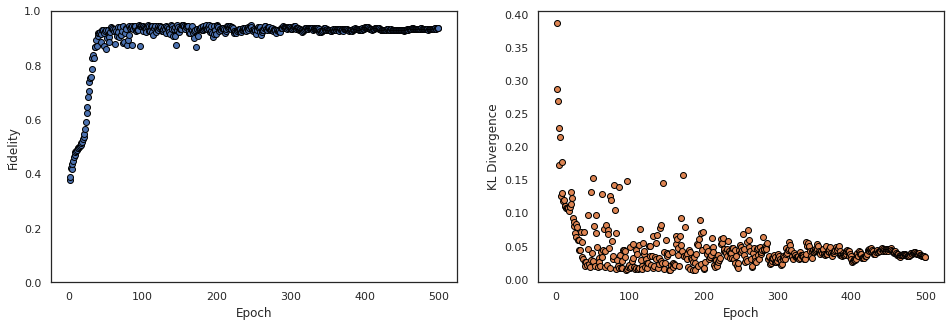

In [29]:
fidelities = callbacks[0]["Fidelity"]
KLs = callbacks[0]["KL_Divergence"]
epoch_range = np.arange(period, epoch + 1, period)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))
ax = axs[0]
ax.plot(epoch_range, fidelities, "o", color = "C0", markeredgecolor = "black")
ax.set_ylabel(r"Fidelity")
ax.set_xlabel(r"Epoch")
ax.set_ylim(0.00, 1.00)

ax = axs[1]
ax.plot(epoch_range, KLs, "o", color = "C1", markeredgecolor = "black")
ax.set_ylabel(r"KL Divergence")
ax.set_xlabel(r"Epoch")

## save model & train log

In [31]:
# save model
nn_state_dm.save("./exp001/model.pt")
# save train log
train_log_df = pd.DataFrame()
train_log_df["epoch"] = np.arange(period, epoch+1, period)
train_log_df["Fidelity"] = callbacks[0]["Fidelity"]
train_log_df["KL_Divergence"] = callbacks[0]["KL_Divergence"]
train_log_df["Observable_XXX_ev"] = callbacks[0]["Observable_XXX_ev"]
train_log_df["Observable_XZZ_ev"] = callbacks[0]["Observable_XZZ_ev"]
train_log_df.to_csv("./exp001/train_log.csv", index=False)